In [1]:
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
import itertools
import os
import shutil

import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import json
import kerastuner as kt
import PIL

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
GOOD = 0
BAD = 1

325


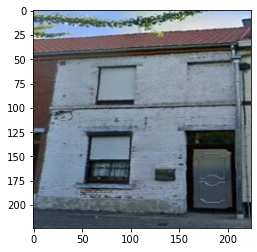

In [3]:
with open('/home/jupyter/large-dataset/_annotations.json') as json_file: 
    annot = json.load(json_file) 
data=[]
labels=[]
imagePaths = []
data_dir="/home/jupyter/data"
for label in os.listdir(data_dir):
    listdir = os.listdir(os.path.sep.join([data_dir,label]))
    if label == 'Good':
        bin_label = GOOD
    elif label == 'Bad':
        bin_label = BAD
    for filename in listdir:
        imagePath = os.path.sep.join([data_dir, label, filename])
        image = cv2.imread(imagePath)
        for item in annot['annotations']:
            if item == filename: 
                x = annot['annotations'][item][0]['x']
                y = annot['annotations'][item][0]['y']
                x2 = annot['annotations'][item][0]['x2']
                y2 = annot['annotations'][item][0]['y2']
        image = load_img(imagePath)
        width, height = image.size 
        image = image.crop((x*width, y*height, x2*width, y2*height))
        image = image.resize(IMAGE_SIZE)
        plt.imshow(image)
        image = img_to_array(image) / 255.0
        data.append(image)
        labels.append(bin_label)
        imagePaths.append(imagePath)
data = np.array(data)
labels = np.array(labels)
imagePaths = np.array(imagePaths)
print(len(data))

In [4]:
#splitting  dataset
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 70% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=1 - train_ratio)

# test is now 15% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [5]:
def model_builder(hp):
    resnet = ResNet50V2(weights='imagenet', include_top = False, input_shape=(IMAGE_SIZE +(3,)))
    head = resnet.output
    head = GlobalAveragePooling2D()(head)
    head = BatchNormalization()(head)
    hp_rate = hp.Choice('rate', values=[0.0, 0.5, 0.7])
    head = Dropout(hp_rate)(head)
    head = tf.keras.layers.Dense(1, activation="sigmoid",
                              kernel_regularizer=tf.keras.regularizers.l2(0.0001), name="class_label")(head)
    model = Model(
        inputs=resnet.input,
        outputs=(head))
    hp_layers = hp.Choice('num_frozen_layers',  values=[-4, -17, -28, -40])
    for layer in model.layers[:hp_layers]:
        layer.trainable = False
    model.summary()
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
      optimizer=tf.keras.optimizers.SGD(lr=hp_learning_rate),
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1),
      metrics=['accuracy'])
    return model

In [6]:
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='/home/jupyter/Cropping-tuner/',
                     project_name='ResNetMediumTuner')
tuner.search_space_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
#tuning
steps_per_epoch = len(x_train) // BATCH_SIZE
validation_steps = len(x_val) // BATCH_SIZE
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto', verbose=1)
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
tuner.search(x_train, y_train, epochs=50, steps_per_epoch=steps_per_epoch, 
         validation_data=(x_val, y_val), validation_steps=validation_steps, callbacks=[callback])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 12s]
val_accuracy: 0.6734693646430969

Best val_accuracy So Far: 0.795918345451355
Total elapsed time: 00h 08m 52s
INFO:tensorflow:Oracle triggered exit


In [9]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps['learning_rate'])
print(best_hps['num_frozen_layers'])
print(best_hps['rate'])

0.01
-40
0.7


In [10]:
#training
#tf.debugging.set_log_device_placement(True)
#with tf.device('/CPU:0'):
model = tuner.hypermodel.build(best_hps)
hist = model.fit(
    x_train, y_train,
    epochs=50, steps_per_epoch=steps_per_epoch,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps, callbacks=[callback]).history

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

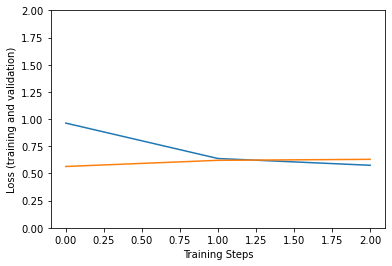

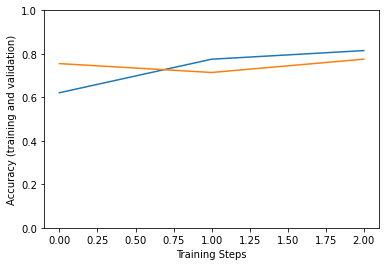

In [11]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [12]:
#https://www.tensorflow.org/tutorials/keras/save_and_load?fbclid=IwAR3JVn-_CLqgNuKO3G92cMYCNqVL81oxVs3bP6QhfgFLPiE4VbEMK2QQffc
loss, acc = model.evaluate(x_test, y_test, verbose=2)

2/2 - 2s - loss: 0.5378 - accuracy: 0.7959


In [13]:
print(len(y_test))
print("%bad test set: " + str(y_test.sum()/len(y_test)))
print(len(y_val))
print("%bad val set: " + str(y_val.sum()/len(y_val)))
print(len(y_train))
print("%bad train set: " + str(y_train.sum()/len(y_train)))

49
%bad test set: 0.32653061224489793
49
%bad val set: 0.2857142857142857
227
%bad train set: 0.2511013215859031


In [14]:
saved_model_path = "/home/jupyter/Cropping-tuner/ResNet-MediumDataModel"
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: /home/jupyter/Cropping-tuner/ResNet-MediumDataModel/assets


In [15]:
model.save('ResNet-MediumDatasetModel.h5')